<a href="https://colab.research.google.com/github/Njarrin/ToxicityTestingCapstonenelsonjarrin/blob/main/Custom_Large_Language_Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import auth
from google.cloud import storage
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Load Training Data from Google Cloud Storage
auth.authenticate_user()
try:
    client = storage.Client()
    bucket = client.bucket('datasetforcapstonenelsonjarrin')
    blob = bucket.blob('sampled_train_2.csv')
    df_train = pd.read_csv(blob.open('r'))
    print("Training data loaded successfully!")
    print("First 5 rows of training data:")
    print(df_train.head())
    print("Columns in Training DataFrame:", df_train.columns)
except Exception as e:
    print(f"Error loading TRAINING DataFrame: {e}")
    exit()

Training data loaded successfully!
First 5 rows of training data:
                 id                                       comment_text  toxic  \
0  f470fbfb8a45a534  No they shouldn't.  Sublime is a ska band not ...      0   
1  0e55e30fdf3a6c4b  To Wikipedia admins \n\nthis is a Internet sit...      0   
2  89b2262b5e59ff03  what kinds of termination of war for world war 2?      0   
3  8ef77637d30feaa5  Also, the article on hull number 1000 Zumwalt ...      0   
4  e8577068eb6afd41  what don't you understand about fair use? does...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Columns in Training DataFrame: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'th

In [ ]:
# 2. Load Testing Data from Google Cloud Storage
try:
    client = storage.Client()
    bucket = client.bucket('datasetforcapstonenelsonjarrin')
    blob = bucket.blob('unhealthy_test.csv')
    df_test = pd.read_csv(blob.open('r'))
    print("Testing data loaded successfully!")
    print("First 5 rows of testing data:")
    print(df_test.head())
    print("Columns in Testing DataFrame:", df_test.columns)
except Exception as e:
    print(f"Error loading TESTING DataFrame: {e}")
    exit()

Testing data loaded successfully!
First 5 rows of testing data:
     _unit_id  _trusted_judgments  \
0  1739450989                   3   
1  1739442069                   5   
2  1739464409                   3   
3  1739447549                   5   
4  1739466909                   3   

                                             comment  antagonize  \
0  When you have Conservative members now feeling...           0   
1  That's one of the problem, as Germany sent out...           0   
2  Yesshe is, and if she was always and only refe...           0   
3  There is nothing honourable about Stephen Harper.           1   
4  What a pathetic piece of writing. I have no re...           0   

   antagonize:confidence  condescending  condescending:confidence  dismissive  \
0                 1.0000              0                    1.0000           0   
1                 0.7955              0                    1.0000           0   
2                 1.0000              0                    1.

In [ ]:
# 3. Define Column Names and Check Existence
text_column = "comment_text"  # Column containing text in training data
label_column = "toxic"      # Column containing labels in training data
test_text_column = "comment"   # Column containing text in testing data

if text_column not in df_train.columns or label_column not in df_train.columns:
    print(f"Error: Columns '{text_column}' and/or '{label_column}' not found in TRAINING data.")
    exit()

if test_text_column not in df_test.columns:
    print(f"Error: Column '{test_text_column}' not found in TESTING data.")
    exit()

In [ ]:
# 4. Prepare Data for Training and Testing
train_texts = df_train[text_column].tolist()
train_labels = df_train[label_column].astype(int).tolist()
test_texts = df_test[test_text_column].tolist()

# Check if labels are available in the test data
if "toxic" in df_test.columns:
    test_labels = df_test["toxic"].astype(int).tolist()
else:
    test_labels = None #if labels do not exist

In [ ]:
# 5. Dataset and Dataloader (Single-Label)
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long) # Single label, torch.long
        }

MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

train_dataset = ToxicDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = ToxicDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# 6. Model, Optimizer, Loss (Single-Label)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # 2 labels (toxic/not toxic)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss() # Correct loss function for single-label


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 7. Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {total_loss/len(train_dataloader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Validation Loss: {val_loss/len(val_dataloader)}")


torch.save(model.state_dict(), 'toxic_comment_model.pth')
print("Training finished. Model saved as toxic_comment_model.pth")


Epoch 1/4, Training Loss: 0.6167884469032288
Epoch 1/4, Validation Loss: 0.47312720119953156
Epoch 2/4, Training Loss: 0.45919032096862794
Epoch 2/4, Validation Loss: 0.28194478154182434
Epoch 3/4, Training Loss: 0.3945368051528931
Epoch 3/4, Validation Loss: 0.19137100130319595
Epoch 4/4, Training Loss: 0.3499722361564636
Epoch 4/4, Validation Loss: 0.1707979217171669
Training finished. Model saved as toxic_comment_model.pth


In [ ]:
# 8. Inference
def predict(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities).item()
    return predicted_class, probabilities[0][1].item() #Returns the probability of the positive class(toxic)

# Store predictions here
predicted_classes = []
toxicity_probs = []

num_predictions = min(len(test_texts),100) #Limit to 100 for comparison
for i in range(num_predictions):
    text = test_texts[i]
    predicted_class, toxicity_prob = predict(text)
    predicted_classes.append(predicted_class)
    toxicity_probs.append(toxicity_prob)

    print(f"Text: {text[:50]}...")
    print(f"Predicted Class: {predicted_class}")
    print(f"Toxicity Probability: {toxicity_prob:.4f}")
    if test_labels is not None:
        if i < len(test_labels):
            print(f"True Label: {test_labels[i]}")
        else:
            print("No true label available for this example")
    print("-" * 20)

Text: When you have Conservative members now feeling saf...
Predicted Class: 0
Toxicity Probability: 0.1178
--------------------
Text: That's one of the problem, as Germany sent out the...
Predicted Class: 0
Toxicity Probability: 0.1421
--------------------
Text: Yesshe is, and if she was always and only referred...
Predicted Class: 0
Toxicity Probability: 0.1176
--------------------
Text: There is nothing honourable about Stephen Harper....
Predicted Class: 0
Toxicity Probability: 0.1365
--------------------
Text: What a pathetic piece of writing. I have no respec...
Predicted Class: 0
Toxicity Probability: 0.1987
--------------------
Text: Bernie Sanders is the only one telling the truth t...
Predicted Class: 0
Toxicity Probability: 0.1385
--------------------
Text: But you see how a person's rights (to live or to s...
Predicted Class: 0
Toxicity Probability: 0.1120
--------------------
Text: If only Mr Tory wasn't it should read.....
Predicted Class: 0
Toxicity Probability: 0.1375
-

In [ ]:
# Example Usage with an arbitary new sentence
test_text = "do you love me or not"
predicted_class, toxicity_prob = predict(test_text)
print(f"Test Text: {test_text}")
print(f"Predicted Class: {predicted_class}")
print(f"Toxicity Probability: {toxicity_prob:.4f}")

test_text = "i never loved you"
predicted_class, toxicity_prob = predict(test_text)
print(f"Test Text: {test_text}")
print(f"Predicted Class: {predicted_class}")
print(f"Toxicity Probability: {toxicity_prob:.4f}")

test_text = "you make me miss my ex"
predicted_class, toxicity_prob = predict(test_text)
print(f"Test Text: {test_text}")
print(f"Predicted Class: {predicted_class}")
print(f"Toxicity Probability: {toxicity_prob:.4f}")


Test Text: do you love me or not
Predicted Class: 0
Toxicity Probability: 0.1521
Test Text: i never loved you
Predicted Class: 0
Toxicity Probability: 0.2222
Test Text: you make me miss my ex
Predicted Class: 0
Toxicity Probability: 0.2386


In [ ]:
# 9. Create and Save DataFrame (AFTER inference)
llm_predictions_df = pd.DataFrame({
    "comment": test_texts[:num_predictions],  # Use test_texts
    "predicted_class": predicted_classes,
    "toxicity_prob": toxicity_probs
})

llm_predictions_df.to_csv("llm_predictions.csv", index=False)
print("LLM predictions saved to llm_predictions.csv")


LLM predictions saved to llm_predictions.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  llm_predictions.csv  sample_data  toxic_comment_model.pth


**END OF LLM CODING**



I wanted to see where can I place a threshold.

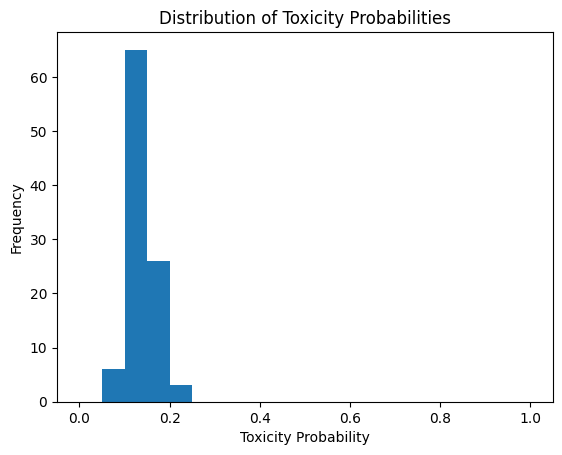

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

llm_predictions_df = pd.read_csv("llm_predictions.csv")

plt.hist(llm_predictions_df['toxicity_prob'], bins=20, range=(0,1))  # Adjust bins as needed
plt.title('Distribution of Toxicity Probabilities')
plt.xlabel('Toxicity Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Mean Toxicity Probability:", llm_predictions_df['toxicity_prob'].mean())
print("Median Toxicity Probability:", llm_predictions_df['toxicity_prob'].median())
print("Standard Deviation of Toxicity Probability:", llm_predictions_df['toxicity_prob'].std())
print("Min Toxicity Probability:", llm_predictions_df['toxicity_prob'].min())
print("Max Toxicity Probability:", llm_predictions_df['toxicity_prob'].max())

Mean Toxicity Probability: 0.13480500794947145
Median Toxicity Probability: 0.12990324944257736
Standard Deviation of Toxicity Probability: 0.027780550386293255
Min Toxicity Probability: 0.0840108469128608
Max Toxicity Probability: 0.2332378625869751


In [ ]:
threshold = 0.5
toxic_count = (llm_predictions_df['toxicity_prob'] > threshold).sum()
total_count = len(llm_predictions_df)
print(f"Number of comments classified as toxic (threshold = {threshold}): {toxic_count}")
print(f"Percentage of comments classified as toxic (threshold = {threshold}): {toxic_count / total_count * 100:.2f}%")

Number of comments classified as toxic (threshold = 0.5): 0
Percentage of comments classified as toxic (threshold = 0.5): 0.00%


I saw that no comment was going to be labeled "toxic" so i lowered it to (0.12)

In [ ]:
print(len(llm_predictions_df))

100


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

llm_predictions_df = pd.read_csv("llm_predictions.csv")

thresholds = [0.05, 0.1, 0.15, 0.2]

for threshold in thresholds:
    toxic_count = (llm_predictions_df['toxicity_prob'] > threshold).sum()
    total_count = len(llm_predictions_df)
    print(f"Threshold: {threshold}")
    print(f"Number of comments classified as toxic: {toxic_count}")
    print(f"Percentage of comments classified as toxic: {toxic_count / total_count * 100:.2f}%\n")

Threshold: 0.05
Number of comments classified as toxic: 100
Percentage of comments classified as toxic: 100.00%

Threshold: 0.1
Number of comments classified as toxic: 94
Percentage of comments classified as toxic: 94.00%

Threshold: 0.15
Number of comments classified as toxic: 29
Percentage of comments classified as toxic: 29.00%

Threshold: 0.2
Number of comments classified as toxic: 3
Percentage of comments classified as toxic: 3.00%

